In [1]:
!pip install pytorch-forecasting


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [200]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [65]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [201]:
data = pd.read_csv('/content/final_dataset.csv')
data.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_x,Dept,Weekly_Sales,IsHoliday_y,Type,Size
0,1,05/02/2010,42.31,2.572,211.096358,8.106,False,1,24924.50,False,A,151315
1,1,05/02/2010,42.31,2.572,211.096358,8.106,False,2,50605.27,False,A,151315
2,1,05/02/2010,42.31,2.572,211.096358,8.106,False,3,13740.12,False,A,151315
3,1,05/02/2010,42.31,2.572,211.096358,8.106,False,4,39954.04,False,A,151315
4,1,05/02/2010,42.31,2.572,211.096358,8.106,False,5,32229.38,False,A,151315


In [202]:
# Check for missing values in columns
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Store           0
Date            0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday_x     0
Dept            0
Weekly_Sales    0
IsHoliday_y     0
Type            0
Size            0
dtype: int64


In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167903 entries, 0 to 167902
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         167903 non-null  int64  
 1   Date          167903 non-null  object 
 2   Temperature   167903 non-null  float64
 3   Fuel_Price    167903 non-null  float64
 4   CPI           167903 non-null  float64
 5   Unemployment  167903 non-null  float64
 6   IsHoliday_x   167903 non-null  bool   
 7   Dept          167903 non-null  int64  
 8   Weekly_Sales  167903 non-null  float64
 9   IsHoliday_y   167903 non-null  bool   
 10  Type          167903 non-null  object 
 11  Size          167903 non-null  int64  
dtypes: bool(2), float64(5), int64(3), object(2)
memory usage: 13.1+ MB


In [204]:
# Convert object columns to strings
string_columns = ['Store', 'Dept', 'Type', 'IsHoliday_y', 'IsHoliday_x', 'Date']
for col in string_columns:
    data[col] = data[col].astype(str)
    data["Weekly_Sales"] = data["Weekly_Sales"].abs()

In [180]:
data.describe()

,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,Size
count,167903.000000,167903.000000,167903.000000,167903.000000,167903.000000,167903.000000
mean,61.571127,3.308662,181.185269,7.506126,17323.270379,139063.696015
std,18.610249,0.448328,40.252209,1.758536,25016.229552,60711.636501
min,-2.060000,2.514000,126.064000,3.879000,0.000000,34875.000000
25%,48.540000,2.869000,130.792900,6.415000,2547.255000,93188.000000
50%,63.740000,3.372000,195.874257,7.197000,8154.030000,126512.000000
75%,76.970000,3.669000,216.302385,8.107000,21199.820000,202307.000000
max,99.220000,4.468000,227.232807,14.313000,693099.360000,219622.000000


In [205]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming 'data' is a Pandas DataFrame
# Assuming 'data' is a Pandas DataFrame
#numerical_columns = data.select_dtypes(include=['float64', 'int64'])
# Create a StandardScaler instance
#scaler = StandardScaler()

# Scale the numerical data
#scaled_data = scaler.fit_transform(numerical_columns)

datan = pd.DataFrame(scaled_data, columns=numerical_columns.columns)

# List of string (categorical) column names
#string_columns = ['Store', 'Dept', 'Type', 'IsHoliday_y', 'IsHoliday_x','Date']

# Create a DataFrame for the string columns
#categorical_df = data[string_columns]

# Combine numerical and categorical DataFrames
#data = pd.concat([datan, categorical_df], axis=1)


In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167903 entries, 0 to 167902
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         167903 non-null  object 
 1   Date          167903 non-null  object 
 2   Temperature   167903 non-null  float64
 3   Fuel_Price    167903 non-null  float64
 4   CPI           167903 non-null  float64
 5   Unemployment  167903 non-null  float64
 6   IsHoliday_x   167903 non-null  object 
 7   Dept          167903 non-null  object 
 8   Weekly_Sales  167903 non-null  float64
 9   IsHoliday_y   167903 non-null  object 
 10  Type          167903 non-null  object 
 11  Size          167903 non-null  int64  
dtypes: float64(5), int64(1), object(6)
memory usage: 15.4+ MB


In [207]:
# Assuming 'date' is in string format, you can convert it to datetime
data["Date"] = pd.to_datetime(data["Date"], format="%d/%m/%Y")
# Now, you can add the time index
data = (data.merge((data[['Date']].drop_duplicates(ignore_index=True)
.rename_axis('time_idx')).reset_index(), on = ['Date']))

In [208]:
random_sample = data.sample(n=5)
random_sample

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_x,Dept,Weekly_Sales,IsHoliday_y,Type,Size,time_idx
140429,11,2012-05-18,72.53,3.630,225.251202,6.664,False,32,14821.25,False,A,207499,119
164060,13,2012-10-05,61.79,3.815,131.075667,5.621,False,81,34276.77,False,A,219622,139
53134,8,2010-12-17,45.03,2.869,214.751084,6.433,False,6,9468.84,False,A,155078,45
124812,7,2012-02-17,27.03,3.113,196.943271,8.256,False,41,1816.29,False,B,70713,106
113025,9,2011-12-09,37.65,3.158,222.656120,6.054,False,30,1157.41,False,B,125833,96


In [209]:
data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings

In [210]:
data["day_of_week"] = data.Date.dt.dayofweek.astype(str).astype("category")  # categories have be strings
data["week_of_year"] = data.Date.dt.weekofyear.astype(str).astype("category")  # categories have be strings
data["log_Weekly_Sales"] = np.log(data.Weekly_Sales + 1e-8)
data["avg_volume_by_Store"] = data.groupby(["time_idx", "Store"], observed=True).Weekly_Sales.transform("mean")
data["avg_volume_by_Dept"] = data.groupby(["time_idx", "Dept"], observed=True).Weekly_Sales.transform("mean")
data["avg_volume_by_Type"] = data.groupby(["time_idx", "Type"], observed=True).Weekly_Sales.transform("mean")

In [211]:
data.describe()

,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,Size,time_idx,log_Weekly_Sales,avg_volume_by_Store,avg_volume_by_Dept,avg_volume_by_Type
count,167903.000000,167903.000000,167903.000000,167903.000000,167903.000000,167903.000000,167903.000000,167903.000000,167903.000000,167903.000000,167903.000000
mean,61.571127,3.308662,181.185269,7.506126,17323.270379,139063.696015,71.106240,8.685606,17323.270379,17323.270379,17323.270379
std,18.610249,0.448328,40.252209,1.758536,25016.229552,60711.636501,41.308135,1.928281,8837.976264,18932.217300,6443.602571
min,-2.060000,2.514000,126.064000,3.879000,0.000000,34875.000000,0.000000,-18.420681,4072.448594,0.000000,9713.788585
25%,48.540000,2.869000,130.792900,6.415000,2547.255000,93188.000000,35.000000,7.842772,8709.360147,4498.515294,11220.672753
50%,63.740000,3.372000,195.874257,7.197000,8154.030000,126512.000000,71.000000,9.006268,16657.631972,10565.008824,15248.951997
75%,76.970000,3.669000,216.302385,8.107000,21199.820000,202307.000000,107.000000,9.961748,25283.630857,24530.151176,23128.135149
max,99.220000,4.468000,227.232807,14.313000,693099.360000,219622.000000,142.000000,13.448929,54552.663571,263815.577647,40896.555351


In [212]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167903 entries, 0 to 167902
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Store                167903 non-null  object        
 1   Date                 167903 non-null  datetime64[ns]
 2   Temperature          167903 non-null  float64       
 3   Fuel_Price           167903 non-null  float64       
 4   CPI                  167903 non-null  float64       
 5   Unemployment         167903 non-null  float64       
 6   IsHoliday_x          167903 non-null  object        
 7   Dept                 167903 non-null  object        
 8   Weekly_Sales         167903 non-null  float64       
 9   IsHoliday_y          167903 non-null  object        
 10  Type                 167903 non-null  object        
 11  Size                 167903 non-null  int64         
 12  time_idx             167903 non-null  int64         
 13  month         

In [213]:
# Check for missing values in columns
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Store                  0
Date                   0
Temperature            0
Fuel_Price             0
CPI                    0
Unemployment           0
IsHoliday_x            0
Dept                   0
Weekly_Sales           0
IsHoliday_y            0
Type                   0
Size                   0
time_idx               0
month                  0
day_of_week            0
week_of_year           0
log_Weekly_Sales       0
avg_volume_by_Store    0
avg_volume_by_Dept     0
avg_volume_by_Type     0
dtype: int64


In [214]:
#data.drop('log_Weekly_Sales', axis=1, inplace=True)

In [215]:
data["time_idx"].max()

142

In [216]:
# Check for missing values in columns
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Store                  0
Date                   0
Temperature            0
Fuel_Price             0
CPI                    0
Unemployment           0
IsHoliday_x            0
Dept                   0
Weekly_Sales           0
IsHoliday_y            0
Type                   0
Size                   0
time_idx               0
month                  0
day_of_week            0
week_of_year           0
log_Weekly_Sales       0
avg_volume_by_Store    0
avg_volume_by_Dept     0
avg_volume_by_Type     0
dtype: int64


In [217]:
max_prediction_length = 12 # Number of months to predict = 6 (here)
max_encoder_length = data.Date.nunique()

training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Weekly_Sales",
    group_ids=["Store", "Dept", "Type"],
    min_encoder_length=max_encoder_length // 2, # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Store", "Dept", "Type"],
    time_varying_known_categoricals=["month", "week_of_year", "day_of_week","IsHoliday_x","IsHoliday_y"],
    #variable_groups={"IsHoliday_x": IsHoliday_x},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Weekly_Sales",
        "log_Weekly_Sales",
        "avg_volume_by_Store",
        "avg_volume_by_Dept",
        "avg_volume_by_Type",
    ],
    target_normalizer=GroupNormalizer(
        groups=["Store", "Dept", "Type"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True  # Add this line to allow missing timesteps
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

In [218]:
# create dataloaders for model
batch_size = 128  # setting it between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Create baseline model:

Evaluating a pytorch_forecasting.models.baseline.Baseline model that predicts the next 6 months by simply repeating the last observed volume gives us a simle benchmark that we want to outperform.

In [219]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(2554.4136)

a MAE of 2554.41 means that, on average, in the baseline model's predictions are off by approximately 2439.20 units (units of "Weekly_Sales" are) from the actual sales values in your validation dataset.

# **Train the Temporal Fusion Transformer**

model architectecture
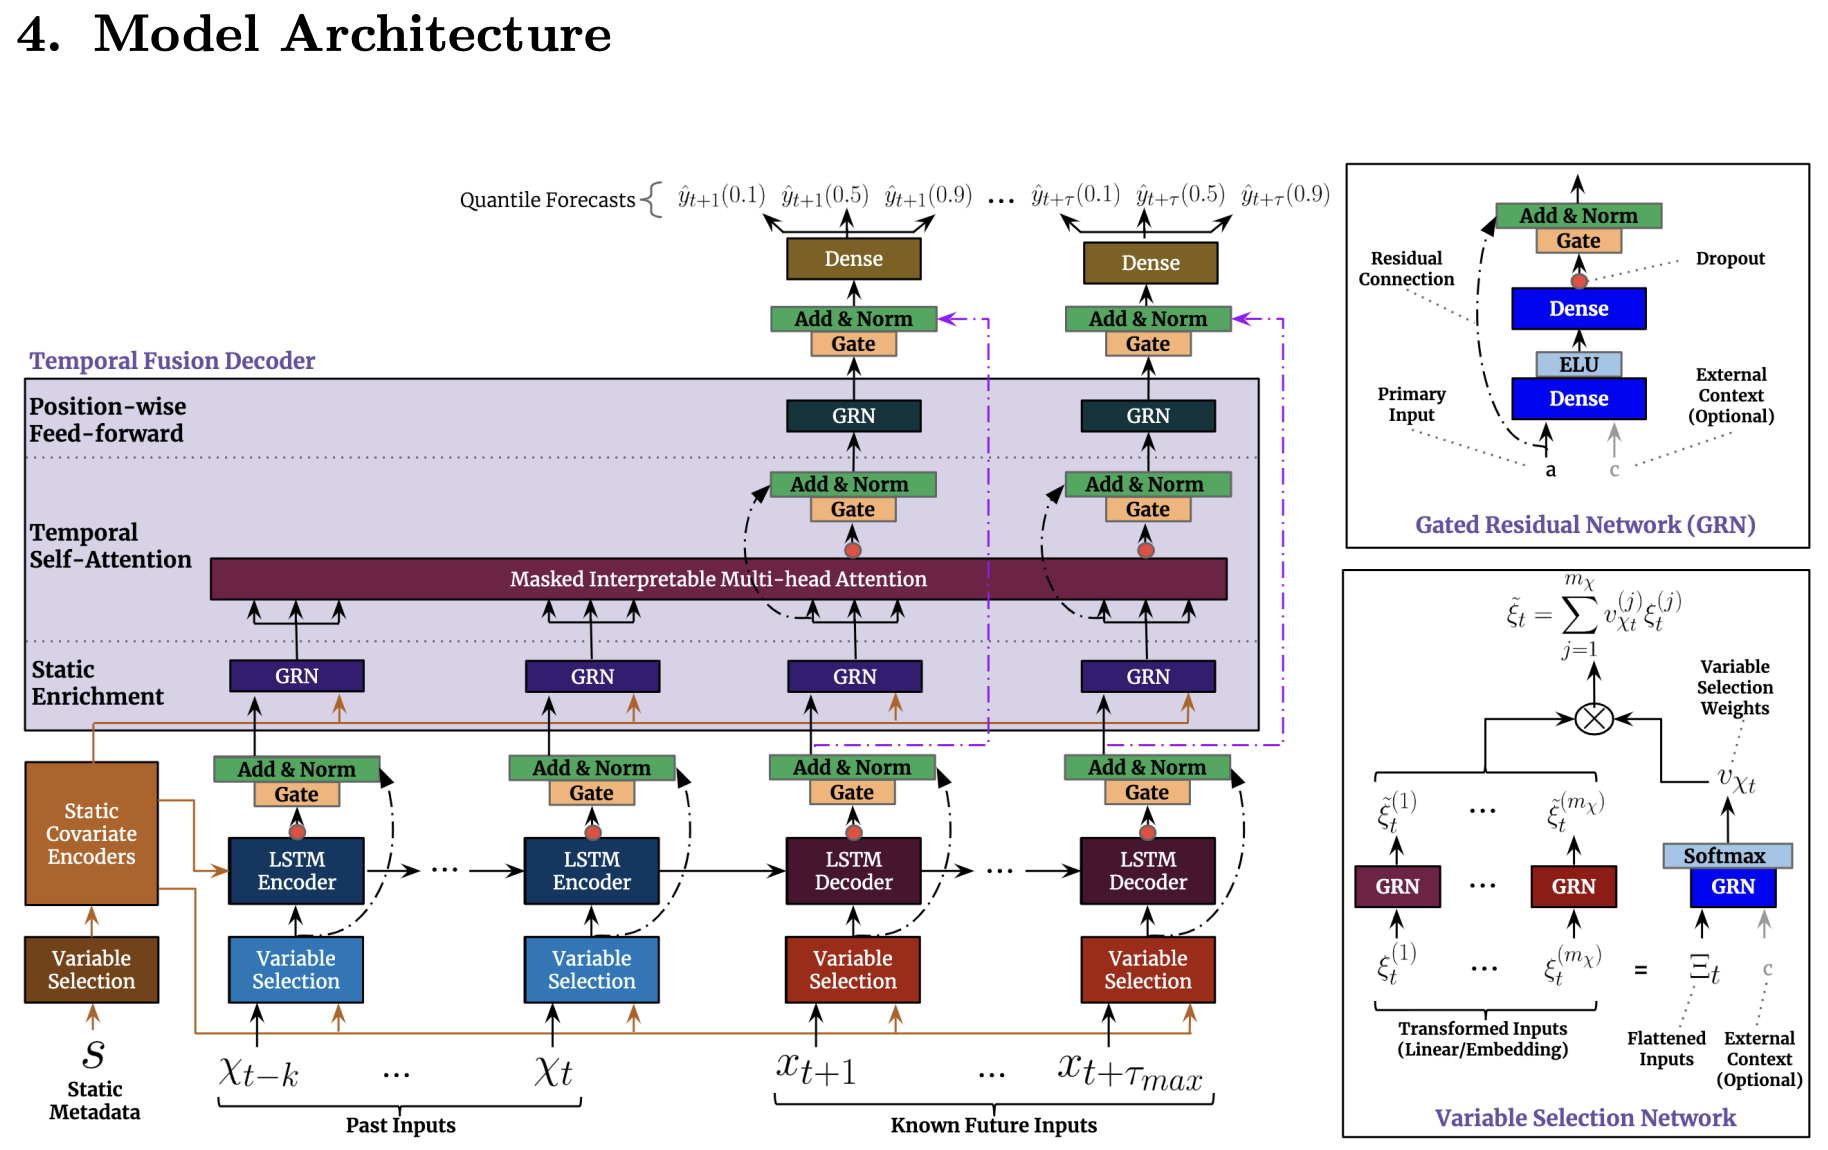

In [220]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Global seed set to 42
INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


Number of parameters in network: 11.2k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: Learning rate set to 9.549925860214362e-06
INFO: Learning rate set to 9.549925860214362e-06
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 9.549925860214362e-06


suggested learning rate: 9.549925860214362e-06


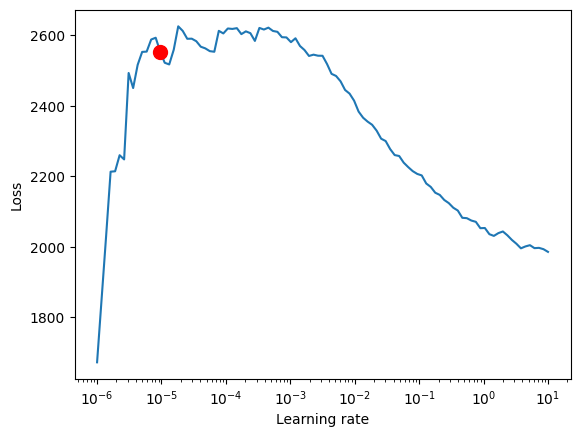

In [221]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [222]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.3,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 25.9k


In [223]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2.3 K 
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

**Hyperparameter tuning**



**Evaluate performance**

PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [224]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [225]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(2139.3303)

In [226]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

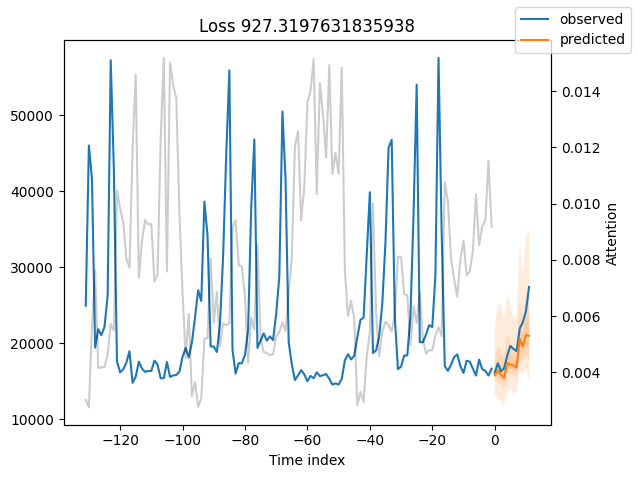

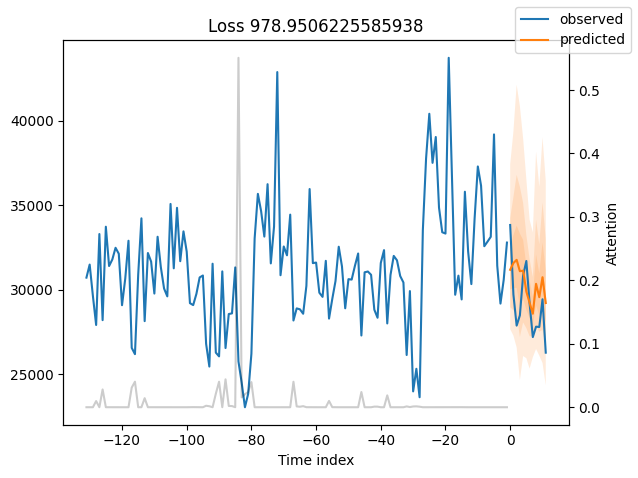

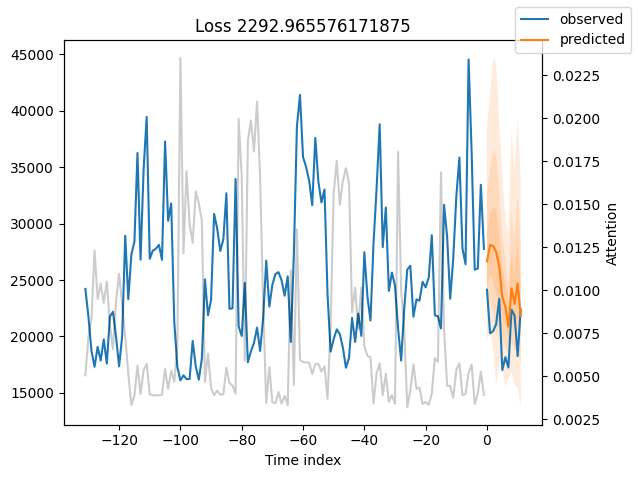

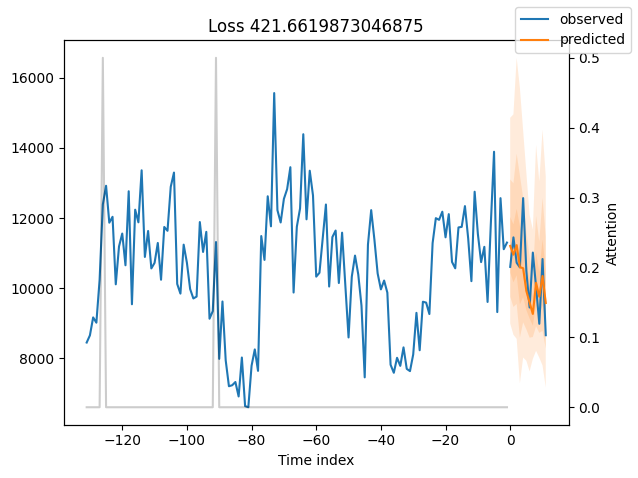

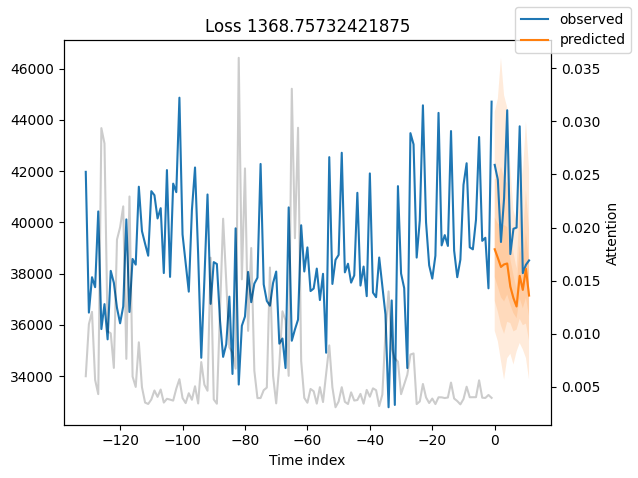

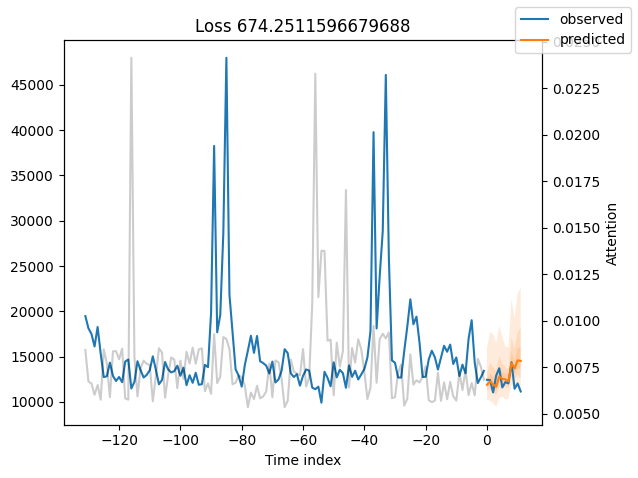

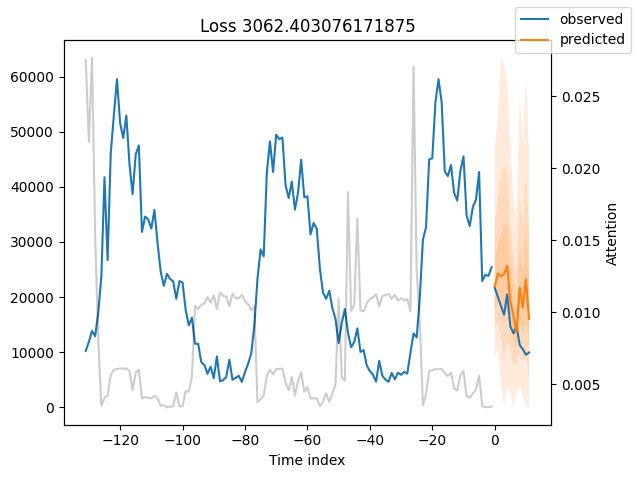

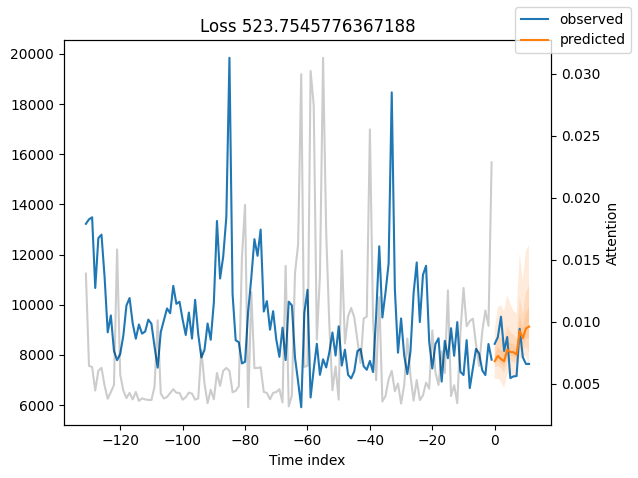

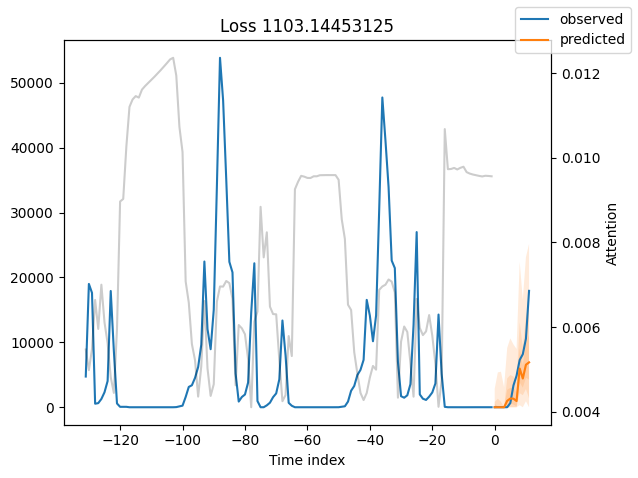

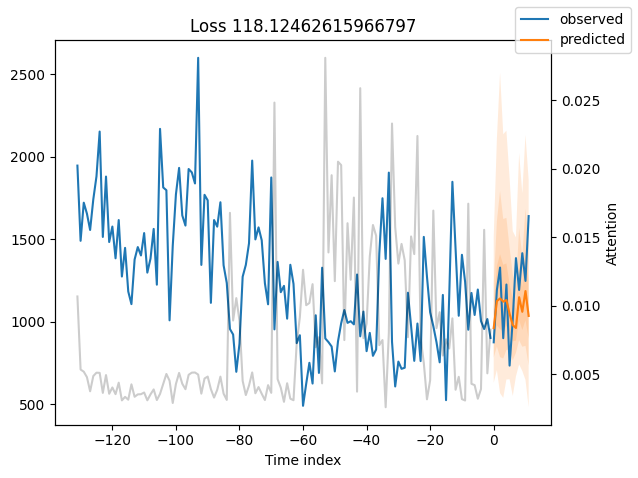

In [227]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

**Worst performers**

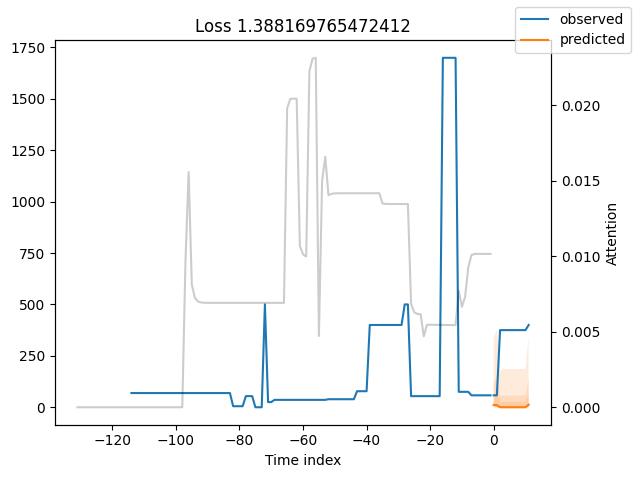

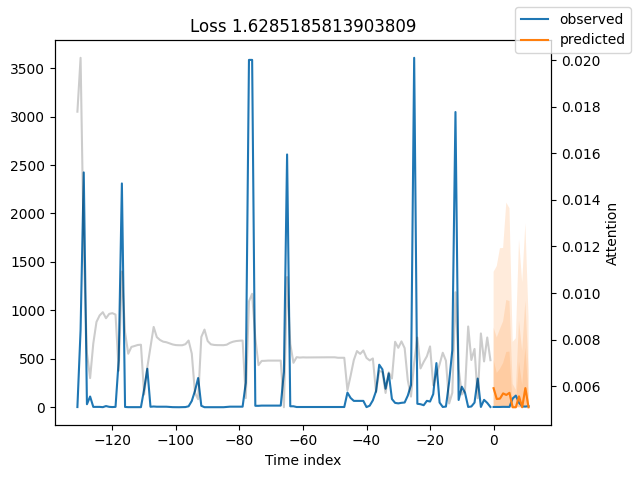

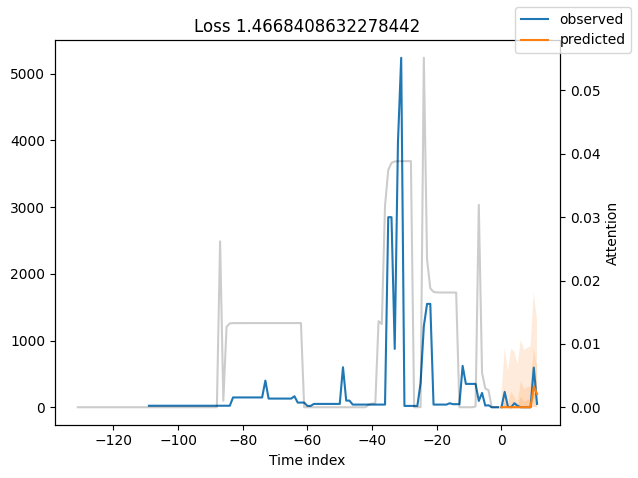

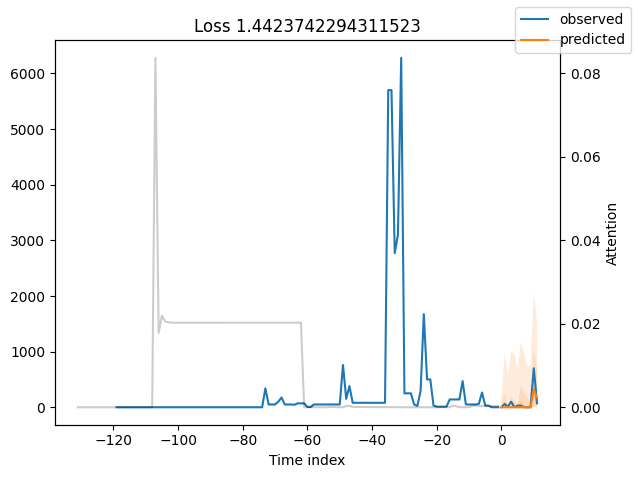

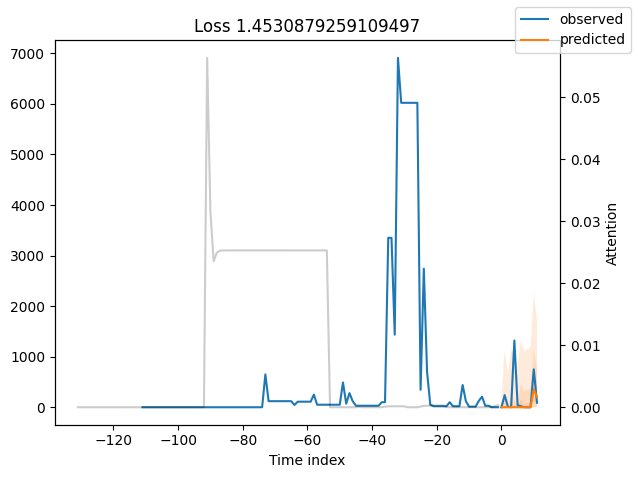

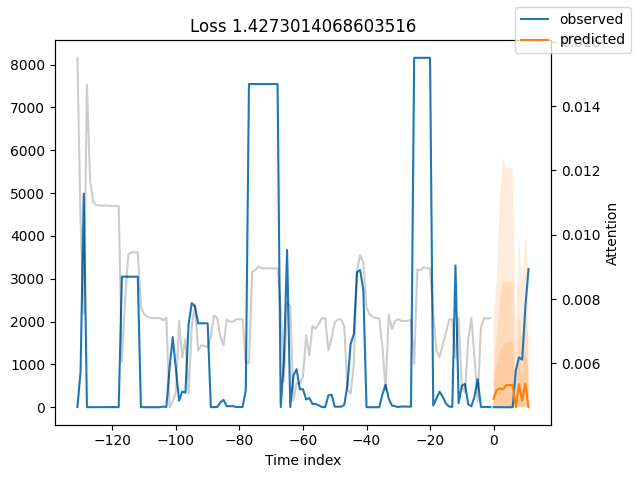

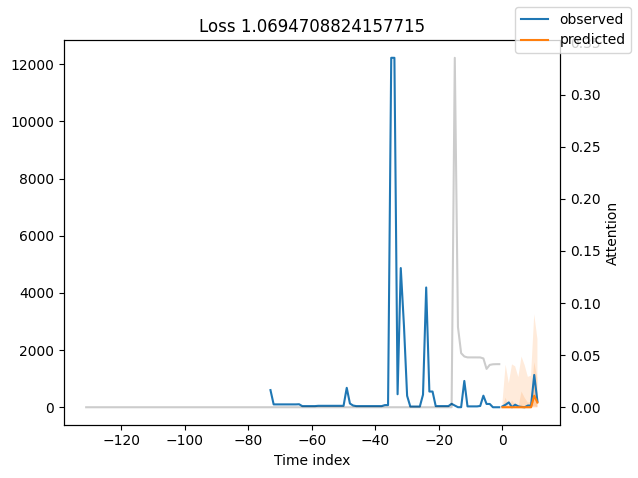

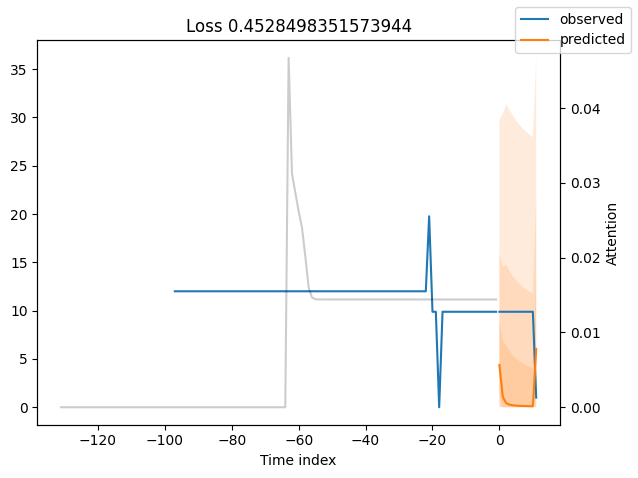

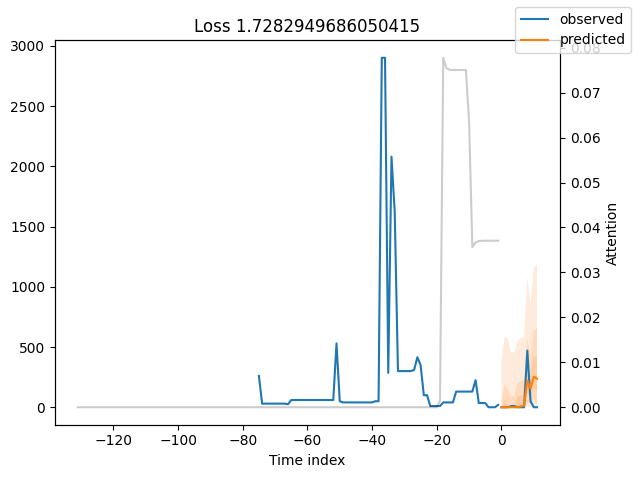

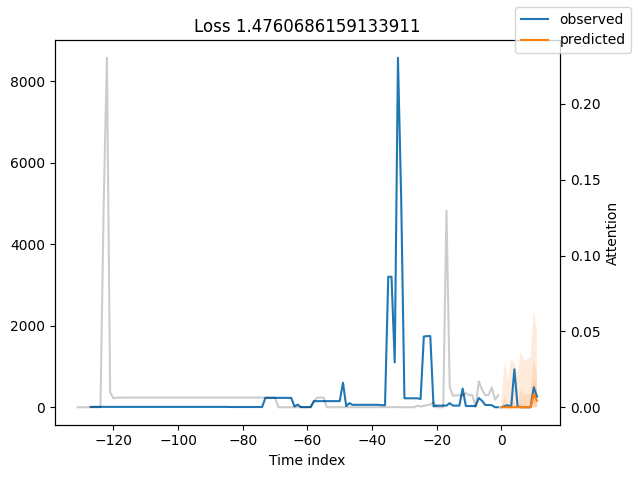

In [228]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

**Actuals vs predictions by variables**

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Weekly_Sales_center': <Figure size 1000x500 with 2 Axes>,
 'Weekly_Sales_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Weekly_Sales': <Figure size 1000x500 with 2 Axes>,
 'log_Weekly_Sales': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_Store': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_Dept': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_Type': <Figure size 1000x500 with 2 Axes>,
 'Store': <Figure size 1000x500 with 2 Axes>,
 'Dept': <Figure size 1000x500 with 2 Axes>,
 'Type': <Figure size 640x480 with 2 Axes>,
 'month': <Figure size 1000x500 with 2 Axes>,
 'week_of_year': <Figure size 1000x500 with 2 Axes>,
 'day_of_week': <Figure size 640x480 with 2 Axes>,
 'IsHoliday_x': <Figure size 640x480 with 2 Axes>,
 'IsHoliday_y': <Figure size 640x480 with 2 Axes>}

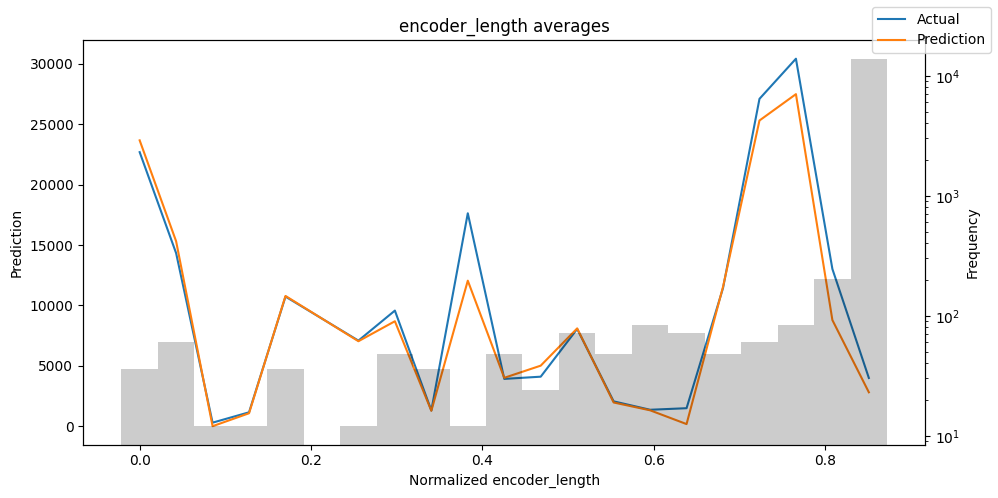

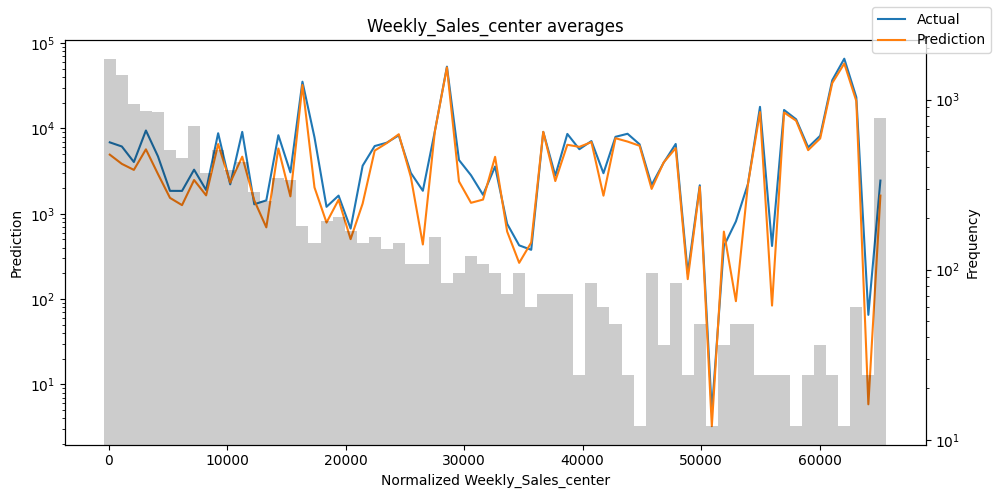

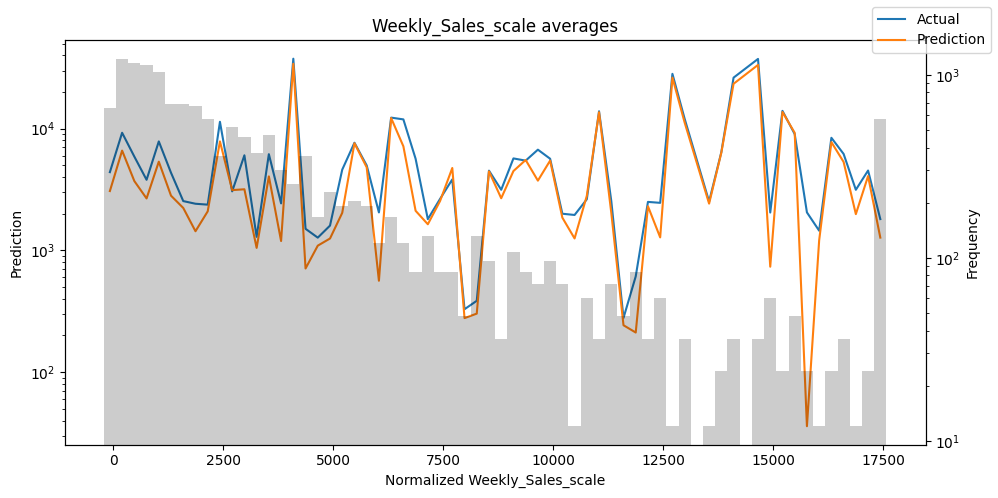

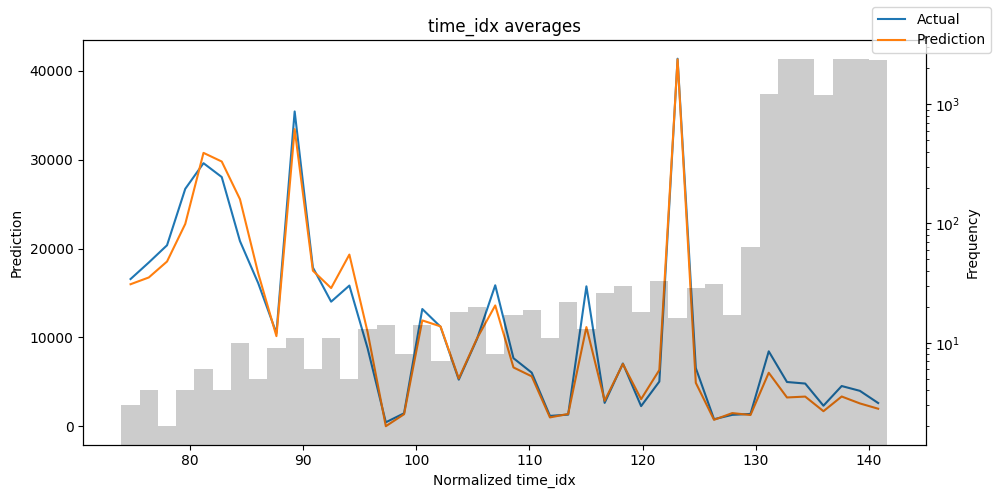

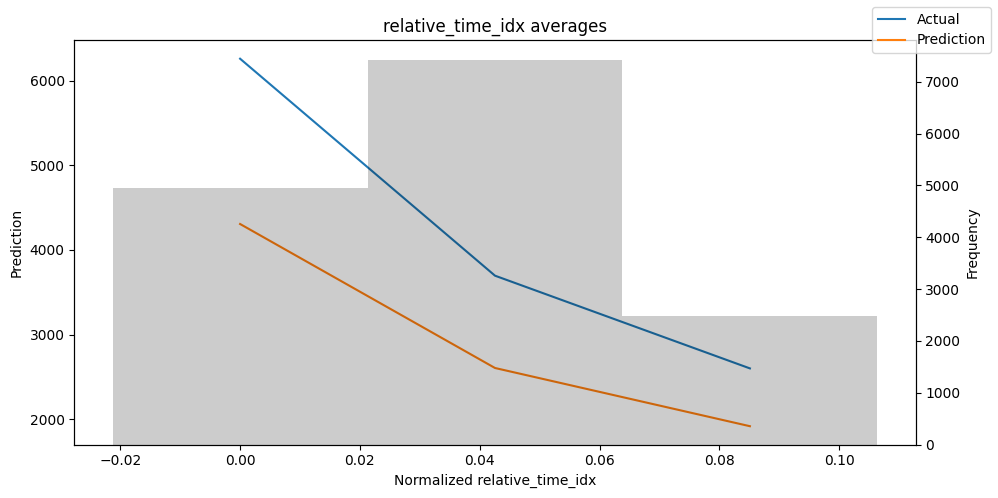

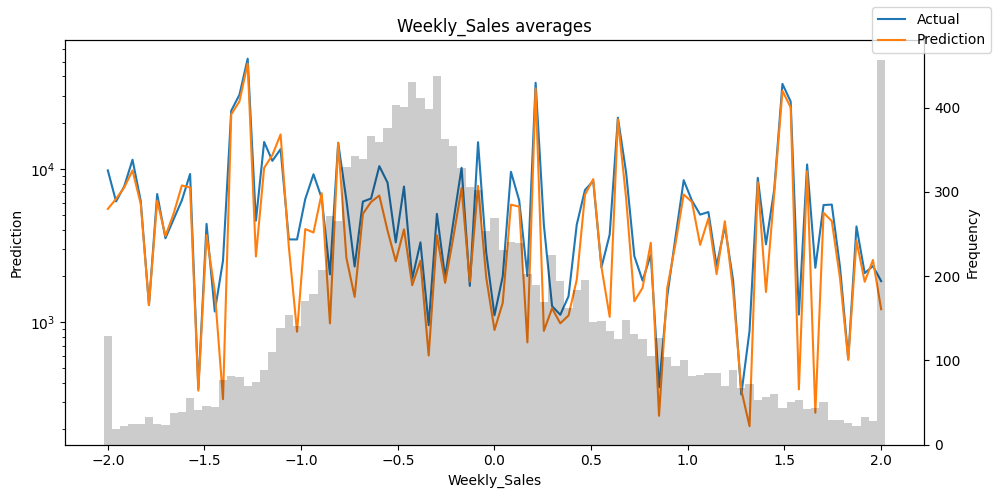

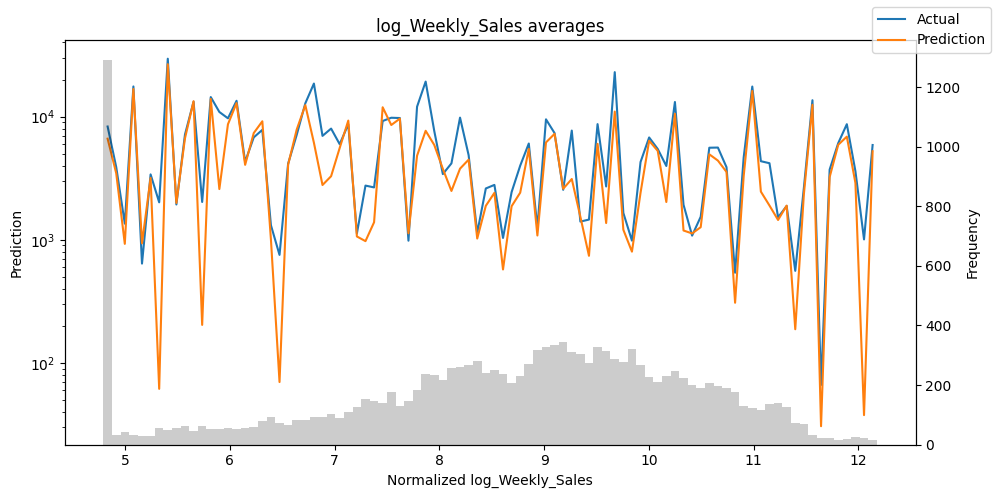

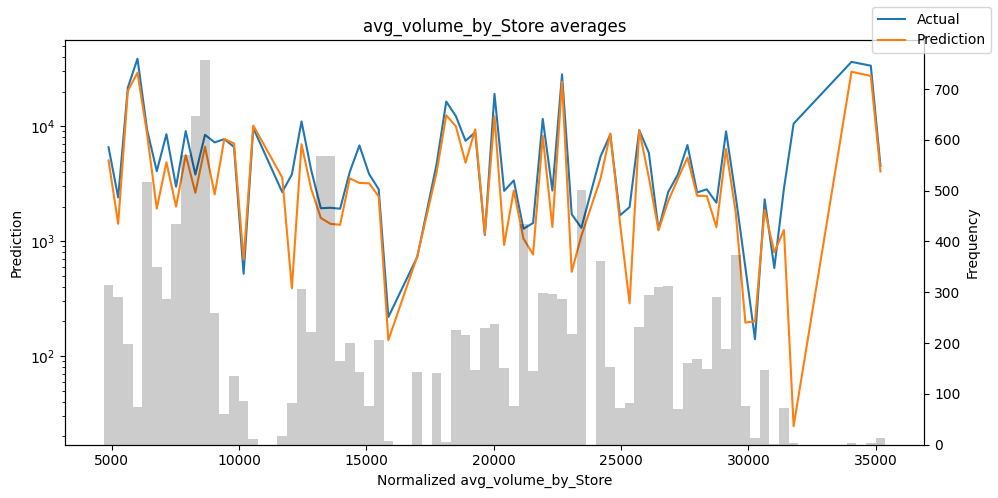

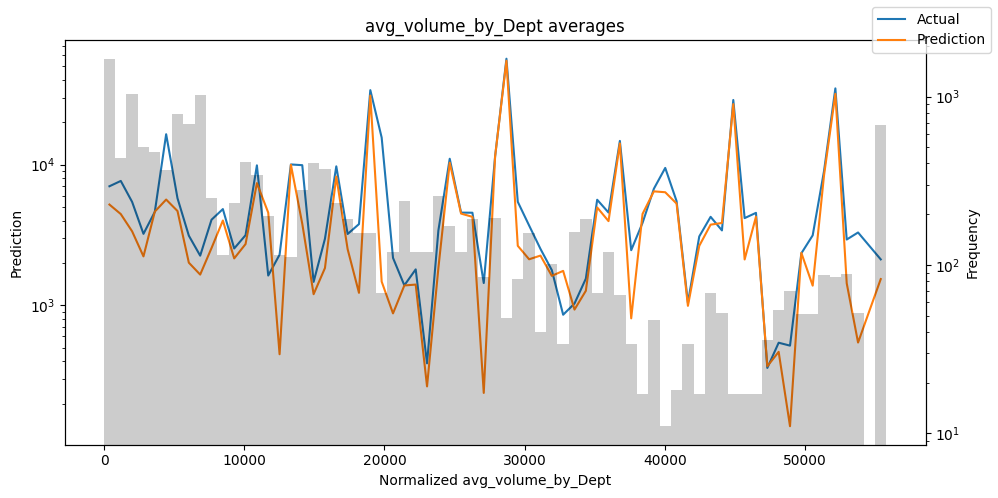

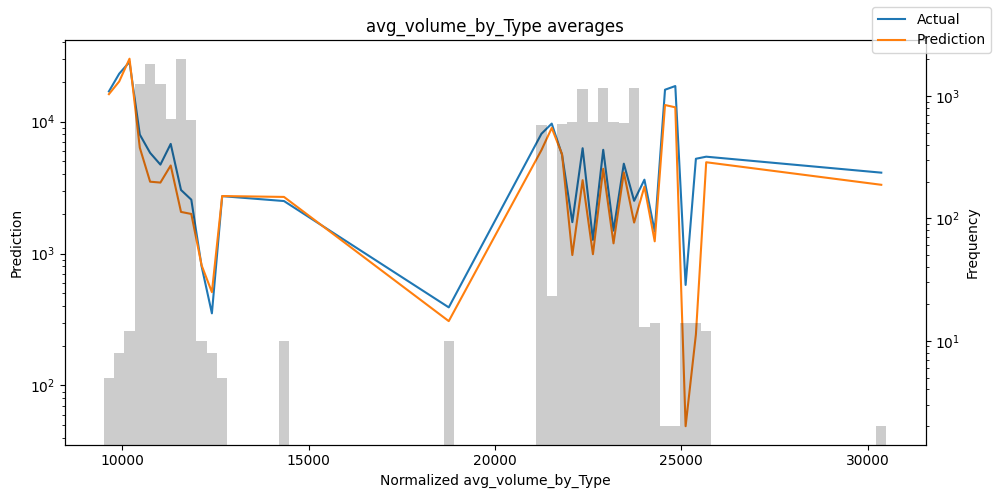

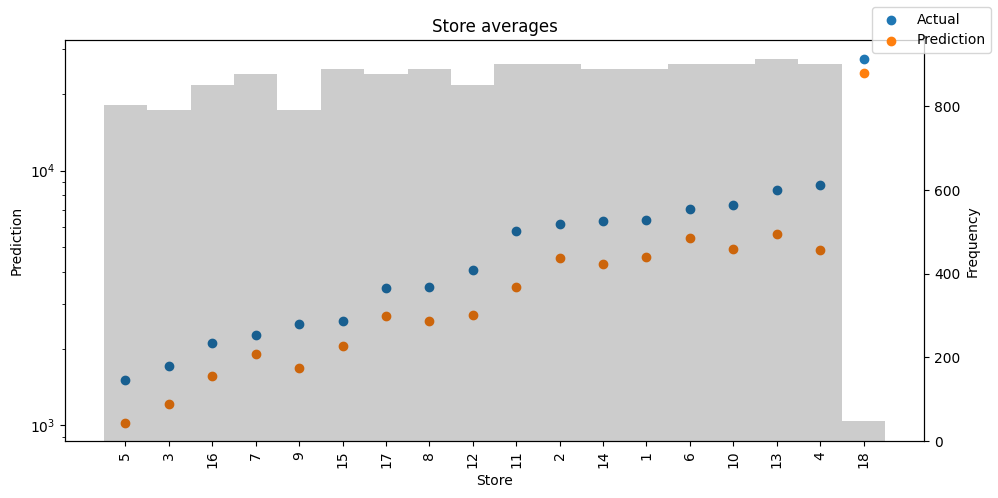

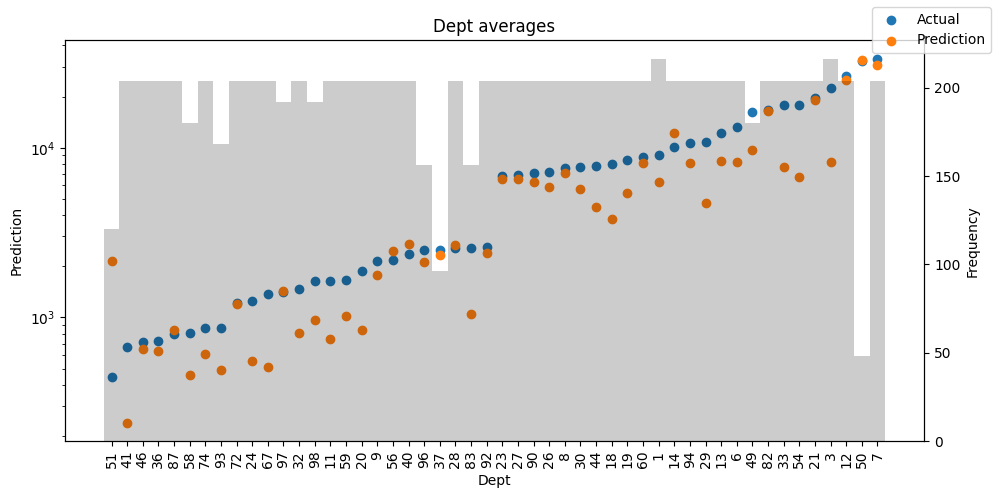

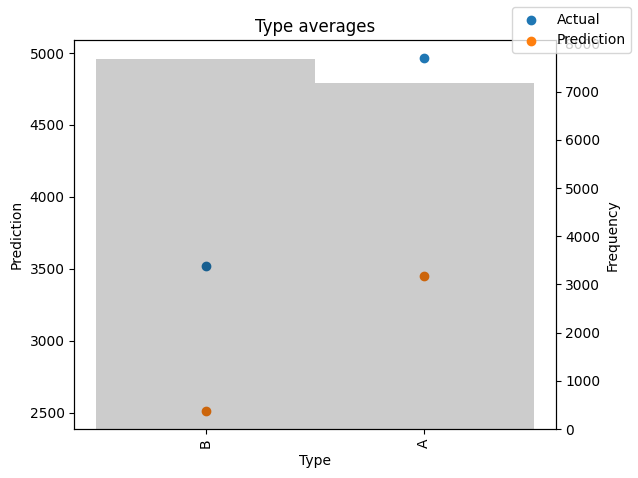

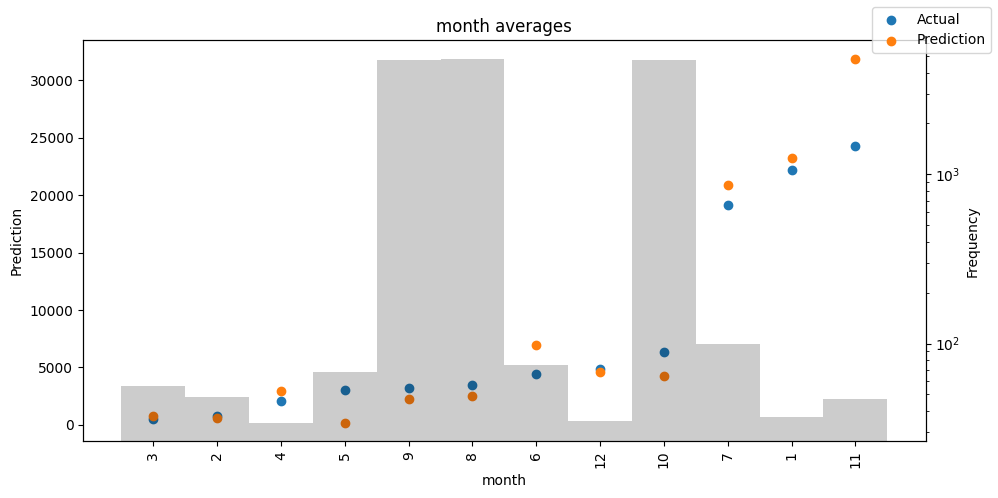

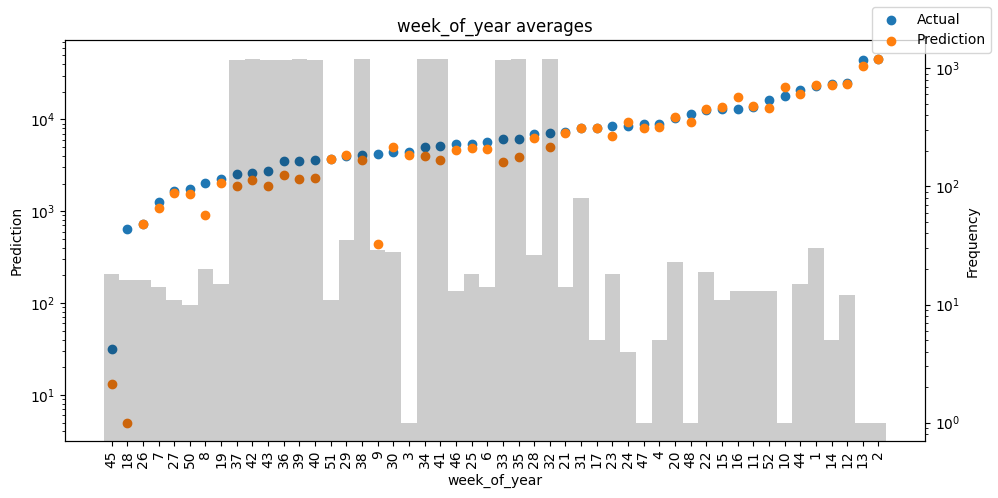

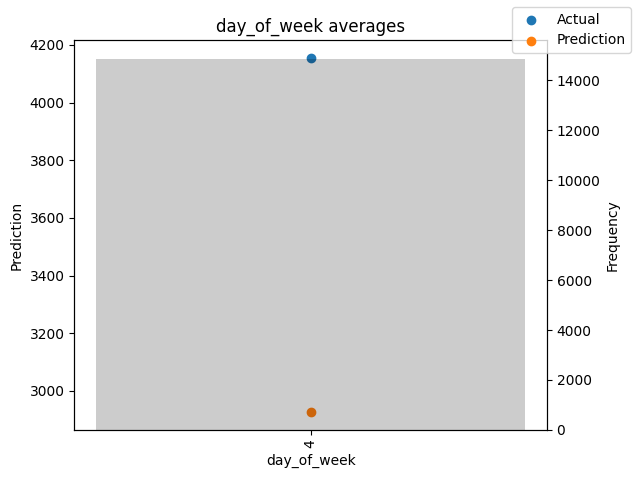

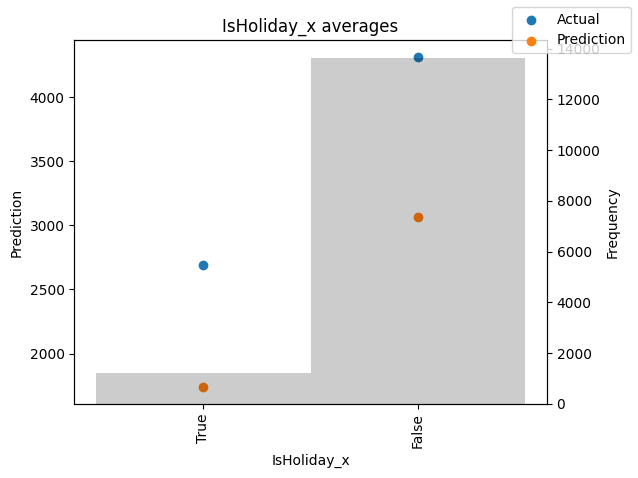

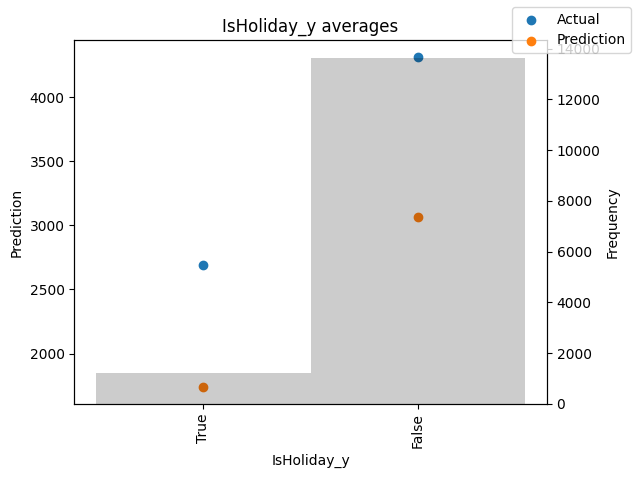

In [229]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)